In [2]:
import tensorflow as tf
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from tqdm import tqdm
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import os
import importlib

dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
randseed = 42
print("random seed: ", randseed)
np.random.seed(randseed)

def choose_data(dat, test_size, val_size):
    if dat == 'ml2':
        train = pd.read_csv(os.path.join(dir_ml, 'ml_train2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_ml, 'ml_test2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        val = None  # Assuming no validation set for 'ml2'
        user_ids = train['userId'].unique()
        item_ids = train['songId'].unique()
        n_users = len(user_ids)
        n_items = len(item_ids)
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_ml, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        user_ids = ml_full['userId'].unique()
        item_ids = ml_full['songId'].unique()
        n_users = len(user_ids)
        n_items = len(item_ids)
        train, test = train_test_split(ml_full, test_size=test_size, random_state=42)
    else:
        print('Wrong data input')
        return None, None, None, None, None

    print(f"Train set size: {train.shape[0]} ratings")
    print(f"Test set size: {test.shape[0]} ratings")
    return train, test, n_users, n_items

def load_confounders(dat, k, contype):
    CAUSEFIT_DIR = f'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/exposure_output/{dat}_exp_k_{k}.csv'
    conf_df = pd.read_csv(CAUSEFIT_DIR, header=None)
    confounder_data = conf_df.to_numpy().T
    return confounder_data

def load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=False, test_size=0.1, val_size=0.1):
    train, test, n_users, n_items = choose_data(dat, test_size, val_size)




    def build_matrix(df):
        rows = []
        cols = []
        ratings = []
        for line in df.itertuples():
            rows.append(line[1])
            cols.append(line[2])
            ratings.append(line[3])
        return csr_matrix((ratings, (rows, cols)), shape=(n_users, n_items)).todok()

    train_matrix = build_matrix(train)
    test_matrix = build_matrix(test)



    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)
    return train_matrix, test_matrix, n_users, n_items

def run_model(module_name, class_name, k, contype='hpf', dat='ml', use_confounder=False, use_exposure=False, test_size=0.1, val_size=0.1, 
              hidden_neuron=500, learning_rate=0.001, reg_rate=0.1, epoch=20, batch_size=200, verbose=False, T=1, display_step=1000, save_path=None, num_runs=5):
    
    train, test, n_users, n_items = load_data_rating(dat, columns=[0, 1, 2], sep="\t", test_size=test_size, val_size=val_size)
    
    print(f"Loaded data: train={train.shape}, test={test.shape}, user={n_users}, item={n_items}")

    confounder_data = None
    exposure_data = None

    if use_confounder:
        confounder_data = load_confounders(dat, k, contype)
    if use_exposure:
        exposure_data = (train > 0).astype(np.float32).todense().T

    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True

    avg_train_loss_history = []
    avg_test_rmse_history = []

    for run in range(num_runs):
        with tf.compat.v1.Session(config=config) as sess:
            module = importlib.import_module(module_name)
            model_class = getattr(module, class_name)

            final_model = model_class(sess, n_users, n_items, learning_rate=learning_rate, reg_rate=reg_rate, epoch=epoch, batch_size=batch_size, verbose=verbose, T=T, display_step=display_step)
            final_model.build_network(hidden_neuron=hidden_neuron)
            
            if confounder_data is not None and exposure_data is not None:
                final_model.execute(train, test, confounder_data, exposure_data)
            elif confounder_data is not None:
                final_model.execute(train, test, confounder_data)
            else:
                final_model.execute(train, test)

            if run == 0:
                avg_train_loss_history = np.array(final_model.train_loss_history)
                avg_test_rmse_history = np.array(final_model.test_rmse_history)
            else:
                avg_train_loss_history += np.array(final_model.train_loss_history)
                avg_test_rmse_history += np.array(final_model.test_rmse_history)

            if save_path:
                class_folder = os.path.join(save_path, class_name.lower())
                os.makedirs(class_folder, exist_ok=True)
                np.save(os.path.join(class_folder, f'{contype}{epoch}_run_{run}_train_loss_{dat}_k{k}.npy'), np.array(final_model.train_loss_history))
                np.save(os.path.join(class_folder, f'{contype}{epoch}_run_{run}_test_rmse_{dat}_k{k}.npy'), np.array(final_model.test_rmse_history))

    avg_train_loss_history /= num_runs
    avg_test_rmse_history /= num_runs

    if save_path:
        class_folder = os.path.join(save_path, class_name.lower())
        np.save(os.path.join(class_folder, f'{contype}{epoch}_average_train_loss_{dat}_k{k}.npy'), avg_train_loss_history)
        np.save(os.path.join(class_folder, f'{contype}{epoch}_average_test_rmse_{dat}_k{k}.npy'), avg_test_rmse_history)

    print(f"Average Final RMSE: {avg_test_rmse_history[-1]}, Average Final Train Loss: {avg_train_loss_history[-1]}")

    


random seed:  42


In [3]:
def run_all_models(result_path, models, k_values, contype):
    for c in contype:
        for k in k_values:
            for model in models:
                use_confounder = 'conf' in model['module_name']
                use_exposure = 'exp' in model['module_name']
                
                print(f"Running {model['class_name']} with k={k}, use_confounder={use_confounder}, use_exposure={use_exposure}")
                run_model(model['module_name'], model['class_name'], k, c, dat='ml2', use_confounder=use_confounder, use_exposure=use_exposure, test_size=0.1, val_size=0.1, hidden_neuron=500, 
                        learning_rate=0.001, reg_rate=1, epoch=200, batch_size=512, verbose=True, save_path=result_path, num_runs=5)
                
                print(f"Completed {model['class_name']} with k={k}")

result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results2'

models = [
    {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1conf'},
    {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1confexp'},
    {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2confexp'},
    {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3conf'},
    {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3confexp'},
    # {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4conf'},
    # {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4confexp'}
]

k_values = [32]
contype = ['hpf', 'mlp']

run_all_models(result_path, models, k_values, contype)



Running UAutoRec with k=32, use_confounder=False, use_exposure=False
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec.


Training:   0%|          | 1/200 [09:36<31:50:43, 576.10s/epoch, Loss=3.52e+4, RMSE=0.991, MAE=0.801]


UAutoRec.


Training:   0%|          | 1/200 [08:52<29:25:51, 532.42s/epoch, Loss=4e+4, RMSE=0.972, MAE=0.784]


UAutoRec.


Training:   0%|          | 1/200 [07:24<24:35:35, 444.90s/epoch, Loss=3.48e+4, RMSE=0.992, MAE=0.801]


UAutoRec.


Training:   0%|          | 1/200 [07:44<25:41:37, 464.81s/epoch, Loss=4.08e+4, RMSE=0.972, MAE=0.784]


UAutoRec.


Training:   0%|          | 1/200 [07:24<24:33:30, 444.27s/epoch, Loss=4.22e+4, RMSE=0.97, MAE=0.782]


Average Final RMSE: 0.9794307729595573, Average Final Train Loss: 38619.227840909094
Completed UAutoRec with k=32
Running UAutoRec1conf with k=32, use_confounder=True, use_exposure=False
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [09:42<00:00,  2.91s/epoch, Loss=1.69e+4, RMSE=1.12, MAE=0.908] 


UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [11:18<00:00,  3.39s/epoch, Loss=1.64e+4, RMSE=1.14, MAE=0.93]  


UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [10:17<00:00,  3.09s/epoch, Loss=1.67e+4, RMSE=1.12, MAE=0.918] 


UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [11:15<00:00,  3.38s/epoch, Loss=1.7e+4, RMSE=1.13, MAE=0.927]  


UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [11:21<00:00,  3.41s/epoch, Loss=1.65e+4, RMSE=1.14, MAE=0.929] 


Average Final RMSE: 1.1306764713391655, Average Final Train Loss: 16708.97121803977
Completed UAutoRec1conf with k=32
Running UAutoRec1confexp with k=32, use_confounder=True, use_exposure=True
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [14:30<00:00,  4.35s/epoch, Loss=1.72e+4, RMSE=1.15, MAE=0.947] 


UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [13:10<00:00,  3.95s/epoch, Loss=1.64e+4, RMSE=1.15, MAE=0.945] 


UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [13:13<00:00,  3.97s/epoch, Loss=1.49e+4, RMSE=1.12, MAE=0.911] 


UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [13:13<00:00,  3.97s/epoch, Loss=1.54e+4, RMSE=1.11, MAE=0.905] 


UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [13:55<00:00,  4.18s/epoch, Loss=1.52e+4, RMSE=1.12, MAE=0.918] 


Average Final RMSE: 1.1316611410116346, Average Final Train Loss: 15808.594424715911
Completed UAutoRec1confexp with k=32
Running UAutoRec2conf with k=32, use_confounder=True, use_exposure=False
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [12:11<00:00,  3.66s/epoch, Loss=3.51e+4, RMSE=0.978, MAE=0.791]


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [11:43<00:00,  3.52s/epoch, Loss=3.75e+4, RMSE=0.977, MAE=0.788]


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [11:31<00:00,  3.46s/epoch, Loss=3.77e+4, RMSE=0.978, MAE=0.789]


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [10:36<00:00,  3.18s/epoch, Loss=3.68e+4, RMSE=0.977, MAE=0.79] 


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [10:16<00:00,  3.08s/epoch, Loss=3.67e+4, RMSE=0.979, MAE=0.79] 


Average Final RMSE: 0.9777684335237797, Average Final Train Loss: 36772.375532670456
Completed UAutoRec2conf with k=32
Running UAutoRec2confexp with k=32, use_confounder=True, use_exposure=True
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [12:59<00:00,  3.90s/epoch, Loss=3.19e+4, RMSE=0.982, MAE=0.789]


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [12:58<00:00,  3.89s/epoch, Loss=3.35e+4, RMSE=0.978, MAE=0.79] 


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [13:11<00:00,  3.96s/epoch, Loss=3.21e+4, RMSE=0.988, MAE=0.799]


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [12:56<00:00,  3.88s/epoch, Loss=3.34e+4, RMSE=0.985, MAE=0.797]


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [13:00<00:00,  3.90s/epoch, Loss=3.13e+4, RMSE=0.991, MAE=0.804]


Average Final RMSE: 0.9848492319884125, Average Final Train Loss: 32434.197123579543
Completed UAutoRec2confexp with k=32
Running UAutoRec3conf with k=32, use_confounder=True, use_exposure=False
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [09:00<00:00,  2.70s/epoch, Loss=3.78e+4, RMSE=0.975, MAE=0.787]


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [09:05<00:00,  2.73s/epoch, Loss=3.57e+4, RMSE=0.987, MAE=0.8]  


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [09:08<00:00,  2.74s/epoch, Loss=3.53e+4, RMSE=0.985, MAE=0.798]


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [09:10<00:00,  2.75s/epoch, Loss=3.95e+4, RMSE=0.967, MAE=0.779]


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [09:13<00:00,  2.77s/epoch, Loss=4.16e+4, RMSE=0.974, MAE=0.785]


Average Final RMSE: 0.9777315324500121, Average Final Train Loss: 38000.84879261364
Completed UAutoRec3conf with k=32
Running UAutoRec3confexp with k=32, use_confounder=True, use_exposure=True
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [11:38<00:00,  3.49s/epoch, Loss=3.61e+4, RMSE=0.968, MAE=0.777]


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [12:07<00:00,  3.64s/epoch, Loss=3.79e+4, RMSE=0.977, MAE=0.79] 


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [11:18<00:00,  3.39s/epoch, Loss=3.44e+4, RMSE=0.987, MAE=0.799]


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [11:29<00:00,  3.45s/epoch, Loss=3.38e+4, RMSE=0.988, MAE=0.8]  


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [11:26<00:00,  3.43s/epoch, Loss=3.46e+4, RMSE=0.987, MAE=0.799]


Average Final RMSE: 0.9813866632417202, Average Final Train Loss: 35359.387535511356
Completed UAutoRec3confexp with k=32
Running UAutoRec with k=32, use_confounder=False, use_exposure=False
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec.


Training:   0%|          | 1/200 [08:38<28:39:35, 518.47s/epoch, Loss=3.75e+4, RMSE=0.979, MAE=0.788]


UAutoRec.


Training:   0%|          | 1/200 [08:21<27:41:43, 501.02s/epoch, Loss=3.88e+4, RMSE=0.978, MAE=0.787]


UAutoRec.


Training:   0%|          | 1/200 [08:22<27:47:57, 502.90s/epoch, Loss=3.8e+4, RMSE=0.98, MAE=0.791]


UAutoRec.


Training:   0%|          | 1/200 [08:31<28:16:25, 511.48s/epoch, Loss=3.34e+4, RMSE=0.995, MAE=0.809]


UAutoRec.


Training:   0%|          | 1/200 [08:35<28:29:05, 515.30s/epoch, Loss=3.34e+4, RMSE=1, MAE=0.812]


Average Final RMSE: 0.986544549215737, Average Final Train Loss: 36217.61953125
Completed UAutoRec with k=32
Running UAutoRec1conf with k=32, use_confounder=True, use_exposure=False
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [12:31<00:00,  3.76s/epoch, Loss=1.7e+4, RMSE=1.15, MAE=0.945]  


UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [12:50<00:00,  3.85s/epoch, Loss=1.7e+4, RMSE=1.14, MAE=0.935]  


UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [12:08<00:00,  3.64s/epoch, Loss=1.68e+4, RMSE=1.13, MAE=0.919] 


UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [12:06<00:00,  3.63s/epoch, Loss=1.68e+4, RMSE=1.13, MAE=0.927] 


UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [12:23<00:00,  3.72s/epoch, Loss=1.69e+4, RMSE=1.13, MAE=0.916] 


Average Final RMSE: 1.137037696668516, Average Final Train Loss: 16898.5568359375
Completed UAutoRec1conf with k=32
Running UAutoRec1confexp with k=32, use_confounder=True, use_exposure=True
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [14:52<00:00,  4.46s/epoch, Loss=1.48e+4, RMSE=1.12, MAE=0.906] 


UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [14:28<00:00,  4.34s/epoch, Loss=1.55e+4, RMSE=1.1, MAE=0.889]  


UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [14:55<00:00,  4.48s/epoch, Loss=1.46e+4, RMSE=1.13, MAE=0.917] 


UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [15:08<00:00,  4.54s/epoch, Loss=1.52e+4, RMSE=1.1, MAE=0.895]  


UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 200/200 [14:39<00:00,  4.40s/epoch, Loss=1.5e+4, RMSE=1.12, MAE=0.913]  


Average Final RMSE: 1.1117758209506738, Average Final Train Loss: 15023.727006392044
Completed UAutoRec1confexp with k=32
Running UAutoRec2conf with k=32, use_confounder=True, use_exposure=False
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [11:43<00:00,  3.52s/epoch, Loss=3.72e+4, RMSE=0.977, MAE=0.79] 


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [12:01<00:00,  3.61s/epoch, Loss=3.84e+4, RMSE=0.972, MAE=0.783]


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [12:24<00:00,  3.72s/epoch, Loss=3.41e+4, RMSE=0.99, MAE=0.804] 


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [12:24<00:00,  3.72s/epoch, Loss=3.43e+4, RMSE=0.988, MAE=0.8]  


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [12:07<00:00,  3.64s/epoch, Loss=3.66e+4, RMSE=0.972, MAE=0.782]


Average Final RMSE: 0.9798631310008418, Average Final Train Loss: 36131.50035511363
Completed UAutoRec2conf with k=32
Running UAutoRec2confexp with k=32, use_confounder=True, use_exposure=True
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [14:39<00:00,  4.40s/epoch, Loss=3.23e+4, RMSE=0.976, MAE=0.788]


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [14:35<00:00,  4.38s/epoch, Loss=2.91e+4, RMSE=1, MAE=0.813]    


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [14:50<00:00,  4.45s/epoch, Loss=2.77e+4, RMSE=1.01, MAE=0.824] 


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [14:35<00:00,  4.38s/epoch, Loss=3.08e+4, RMSE=0.987, MAE=0.798]


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [14:44<00:00,  4.42s/epoch, Loss=3.05e+4, RMSE=0.993, MAE=0.804]


Average Final RMSE: 0.9939792187805508, Average Final Train Loss: 30079.112144886363
Completed UAutoRec2confexp with k=32
Running UAutoRec3conf with k=32, use_confounder=True, use_exposure=False
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [10:24<00:00,  3.12s/epoch, Loss=3.84e+4, RMSE=0.978, MAE=0.791]


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [10:53<00:00,  3.27s/epoch, Loss=3.86e+4, RMSE=0.973, MAE=0.783]


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [10:57<00:00,  3.29s/epoch, Loss=3.56e+4, RMSE=0.984, MAE=0.795]


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [11:00<00:00,  3.30s/epoch, Loss=3.88e+4, RMSE=0.968, MAE=0.78] 


UAutoRec with Confounder.


Training: 100%|██████████| 200/200 [11:09<00:00,  3.35s/epoch, Loss=3.93e+4, RMSE=0.979, MAE=0.793]


Average Final RMSE: 0.9762695576951567, Average Final Train Loss: 38152.94854403409
Completed UAutoRec3conf with k=32
Running UAutoRec3confexp with k=32, use_confounder=True, use_exposure=True
Train set size: 994173 ratings
Test set size: 6040 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), user=6040, item=3706
UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [11:43<00:00,  3.52s/epoch, Loss=3.45e+4, RMSE=0.99, MAE=0.798] 


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [12:16<00:00,  3.68s/epoch, Loss=3.31e+4, RMSE=0.992, MAE=0.802]


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [11:43<00:00,  3.52s/epoch, Loss=3.1e+4, RMSE=1, MAE=0.812]     


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [12:21<00:00,  3.71s/epoch, Loss=3.46e+4, RMSE=0.991, MAE=0.801]


UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 200/200 [11:43<00:00,  3.52s/epoch, Loss=3.25e+4, RMSE=0.998, MAE=0.808]


Average Final RMSE: 0.9944849700583352, Average Final Train Loss: 33141.62901278409
Completed UAutoRec3confexp with k=32


Training loss plot saved to C:/Users/Sten Stokroos/Desktop/NEW/zelf/plots_outcome\movielens2_hpf_training_loss_with_ci.png


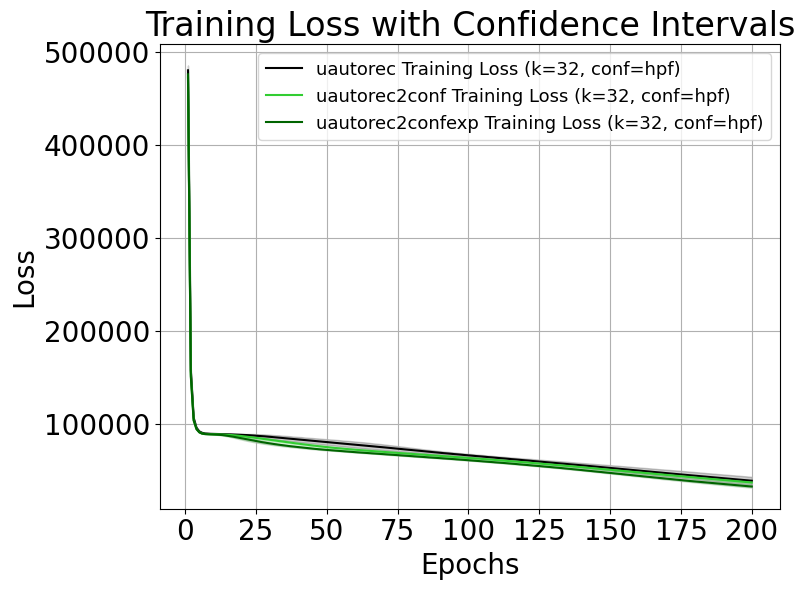

Test RMSE plot saved to C:/Users/Sten Stokroos/Desktop/NEW/zelf/plots_outcome\movielens2_hpf_test_rmse_with_ci.png


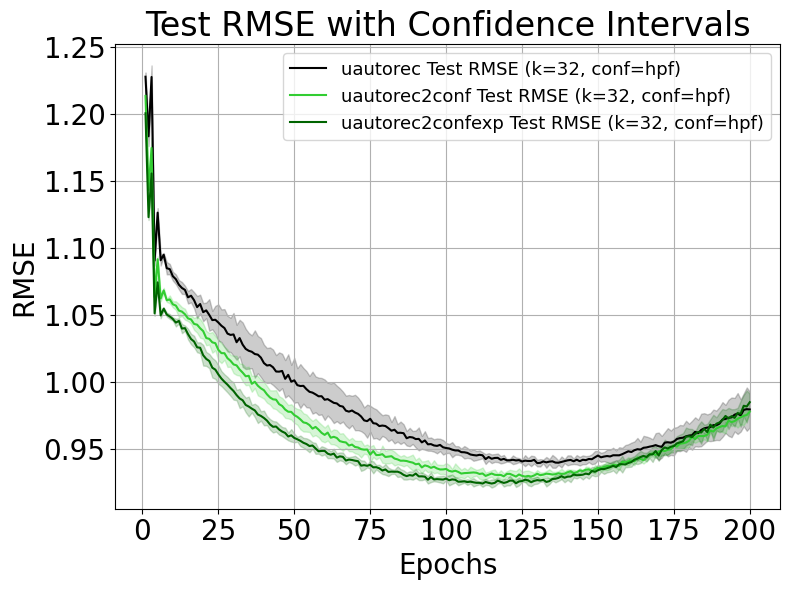

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t
import numpy as np
import os

def load_run_data(class_folder, contype, epoch, dat, k, num_runs):
    run_train_loss_histories = []
    run_test_rmse_histories = []

    for run in range(num_runs):
        train_loss_file = os.path.join(class_folder, f'{contype}{epoch}_run_{run}_train_loss_{dat}_k{k}.npy')
        test_rmse_file = os.path.join(class_folder, f'{contype}{epoch}_run_{run}_test_rmse_{dat}_k{k}.npy')

        if os.path.exists(train_loss_file) and os.path.exists(test_rmse_file):
            train_loss_history = np.load(train_loss_file)
            test_rmse_history = np.load(test_rmse_file)
            run_train_loss_histories.append(train_loss_history)
            run_test_rmse_histories.append(test_rmse_history)

    return np.array(run_train_loss_histories), np.array(run_test_rmse_histories)

def compute_statistics(data):
    """Compute mean, standard deviation, and sample size using .describe() method."""
    desc = pd.DataFrame(data).describe()
    mean = desc.loc['mean'].values
    std = desc.loc['std'].values
    n = desc.loc['count'].values
    return mean, std, n

def compute_confidence_intervals(mean, std, n, confidence_level=0.95):
    t_value = t.ppf((1 + confidence_level) / 2., n-1)
    margin_of_error = t_value * (std / np.sqrt(n))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return lower_bound, upper_bound

def plot_with_confidence_intervals(epochs, mean, lower_bound, upper_bound, label, color):
    plt.plot(epochs, mean, label=label, color=color)
    plt.fill_between(epochs, lower_bound, upper_bound, color=color, alpha=0.2)

def plot_results_with_ci(result_path, models, k_values, contype, save_plots=False, plot_path='C:/Users/Sten Stokroos/Desktop/NEW/zelf/plots_outcome', note='', epoch=200, num_runs=5):
    color_map = {
        'uautorec': 'black',
        'uautorec1conf': 'crimson',
        'uautorec1confexp': 'darkred',
        'uautorec2conf': 'limegreen',
        'uautorec2confexp': 'darkgreen',
        'uautorec3conf': 'lightskyblue',
        'uautorec3confexp': 'navy',
        'uautorec4conf': 'gold',
        'uautorec4confexp': 'orange'
    }

    for c in contype:
        for k in k_values:
            # Plot training loss
            plt.figure(figsize=(8, 6))
            for model in models:
                class_name = model['class_name'].lower()
                class_folder = os.path.join(result_path, class_name)

                run_train_loss_histories, run_test_rmse_histories = load_run_data(class_folder, c, epoch, 'ml2', k, num_runs)

                if run_train_loss_histories.size == 0 or run_test_rmse_histories.size == 0:
                    print(f"No data found for {class_name} with k={k}, conf={c}")
                    continue

                mean_train_loss, std_train_loss, n_train_loss = compute_statistics(run_train_loss_histories)
                lower_train_loss, upper_train_loss = compute_confidence_intervals(mean_train_loss, std_train_loss, n_train_loss)

                epochs = np.arange(1, len(mean_train_loss) + 1)
                color = color_map.get(class_name, 'black')

                plot_with_confidence_intervals(epochs, mean_train_loss, lower_train_loss, upper_train_loss, f'{class_name} Training Loss (k={k}, conf={c})', color)

            plt.xlabel('Epochs', fontsize=20)
            plt.ylabel('Loss', fontsize=20)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            plt.title('Training Loss with Confidence Intervals', fontsize=24)
            plt.legend(fontsize=13)
            plt.grid(True)
            plt.tight_layout()

            if save_plots:
                if not os.path.exists(plot_path):
                    os.makedirs(plot_path)

                plot_file = os.path.join(plot_path, f'{note}_training_loss_with_ci.png')
                plt.savefig(plot_file)
                print(f"Training loss plot saved to {plot_file}")

            plt.show()

            # Plot test RMSE
            plt.figure(figsize=(8, 6))
            for model in models:
                class_name = model['class_name'].lower()
                class_folder = os.path.join(result_path, class_name)

                run_train_loss_histories, run_test_rmse_histories = load_run_data(class_folder, c, epoch, 'ml2', k, num_runs)

                if run_train_loss_histories.size == 0 or run_test_rmse_histories.size == 0:
                    print(f"No data found for {class_name} with k={k}, conf={c}")
                    continue

                mean_test_rmse, std_test_rmse, n_test_rmse = compute_statistics(run_test_rmse_histories)
                lower_test_rmse, upper_test_rmse = compute_confidence_intervals(mean_test_rmse, std_test_rmse, n_test_rmse)

                epochs = np.arange(1, len(mean_test_rmse) + 1)
                color = color_map.get(class_name, 'black')

                plot_with_confidence_intervals(epochs, mean_test_rmse, lower_test_rmse, upper_test_rmse, f'{class_name} Test RMSE (k={k}, conf={c})', color)

            plt.xlabel('Epochs', fontsize=20)
            plt.ylabel('RMSE', fontsize=20)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            plt.title('Test RMSE with Confidence Intervals', fontsize=24)
            plt.legend(fontsize=13)
            plt.grid(True)
            plt.tight_layout()

            if save_plots:
                if not os.path.exists(plot_path):
                    os.makedirs(plot_path)

                plot_file = os.path.join(plot_path, f'{note}_test_rmse_with_ci.png')
                plt.savefig(plot_file)
                print(f"Test RMSE plot saved to {plot_file}")

            plt.show()

# Example usage
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results2'
models = [
    {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2confexp'},
]
k_values = [32]
contype = ['hpf']

plot_results_with_ci(result_path, models, k_values, contype, save_plots=True, plot_path='C:/Users/Sten Stokroos/Desktop/NEW/zelf/plots_outcome', note='movielens2_hpf', epoch=200)


In [ ]:
import tensorflow as tf
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from tqdm import tqdm
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import os
import importlib

dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
randseed = 42
print("random seed: ", randseed)
np.random.seed(randseed)

def choose_data(dat, test_size, val_size):
    if dat == 'ml2':
        train = pd.read_csv(os.path.join(dir_ml, 'ml_train2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_ml, 'ml_test2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        val = None  # Assuming no validation set for 'ml2'
        user_ids = train['userId'].unique()
        item_ids = train['songId'].unique()
        n_users = len(user_ids)
        n_items = len(item_ids)
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_ml, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        user_ids = ml_full['userId'].unique()
        item_ids = ml_full['songId'].unique()
        n_users = len(user_ids)
        n_items = len(item_ids)
        train, test = train_test_split(ml_full, test_size=test_size, random_state=42)
    else:
        print('Wrong data input')
        return None, None, None, None, None

    print(f"Train set size: {train.shape[0]} ratings")
    print(f"Test set size: {test.shape[0]} ratings")
    return train, test, n_users, n_items

def load_confounders(dat, k, contype):
    CAUSEFIT_DIR = f'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/exposure_output/{dat}_exp_k_{k}.csv'
    conf_df = pd.read_csv(CAUSEFIT_DIR, header=None)
    confounder_data = conf_df.to_numpy().T
    return confounder_data

def load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=False, test_size=0.1, val_size=0.1):
    train, test, n_users, n_items = choose_data(dat, test_size, val_size)




    def build_matrix(df):
        rows = []
        cols = []
        ratings = []
        for line in df.itertuples():
            rows.append(line[1])
            cols.append(line[2])
            ratings.append(line[3])
        return csr_matrix((ratings, (rows, cols)), shape=(n_users, n_items)).todok()

    train_matrix = build_matrix(train)
    test_matrix = build_matrix(test)



    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)
    return train_matrix, test_matrix, n_users, n_items

def run_model(module_name, class_name, k, contype='hpf', dat='ml', use_confounder=False, use_exposure=False, test_size=0.1, val_size=0.1, 
              hidden_neuron=500, learning_rate=0.001, reg_rate=0.1, epoch=20, batch_size=200, verbose=False, T=1, display_step=1000, save_path=None, num_runs=5):
    
    train, test, n_users, n_items = load_data_rating(dat, columns=[0, 1, 2], sep="\t", test_size=test_size, val_size=val_size)
    
    print(f"Loaded data: train={train.shape}, test={test.shape}, user={n_users}, item={n_items}")

    confounder_data = None
    exposure_data = None

    if use_confounder:
        confounder_data = load_confounders(dat, k, contype)
    if use_exposure:
        exposure_data = (train > 0).astype(np.float32).todense().T

    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True

    avg_train_loss_history = []
    avg_test_rmse_history = []

    for run in range(num_runs):
        with tf.compat.v1.Session(config=config) as sess:
            module = importlib.import_module(module_name)
            model_class = getattr(module, class_name)

            final_model = model_class(sess, n_users, n_items, learning_rate=learning_rate, reg_rate=reg_rate, epoch=epoch, batch_size=batch_size, verbose=verbose, T=T, display_step=display_step)
            final_model.build_network(hidden_neuron=hidden_neuron)
            
            if confounder_data is not None and exposure_data is not None:
                final_model.execute(train, test, confounder_data, exposure_data)
            elif confounder_data is not None:
                final_model.execute(train, test, confounder_data)
            else:
                final_model.execute(train, test)

            if run == 0:
                avg_train_loss_history = np.array(final_model.train_loss_history)
                avg_test_rmse_history = np.array(final_model.test_rmse_history)
            else:
                avg_train_loss_history += np.array(final_model.train_loss_history)
                avg_test_rmse_history += np.array(final_model.test_rmse_history)

            if save_path:
                class_folder = os.path.join(save_path, class_name.lower())
                os.makedirs(class_folder, exist_ok=True)
                np.save(os.path.join(class_folder, f'{contype}{epoch}_run_{run}_train_loss_{dat}_k{k}.npy'), np.array(final_model.train_loss_history))
                np.save(os.path.join(class_folder, f'{contype}{epoch}_run_{run}_test_rmse_{dat}_k{k}.npy'), np.array(final_model.test_rmse_history))

    avg_train_loss_history /= num_runs
    avg_test_rmse_history /= num_runs

    if save_path:
        class_folder = os.path.join(save_path, class_name.lower())
        np.save(os.path.join(class_folder, f'{contype}{epoch}_average_train_loss_{dat}_k{k}.npy'), avg_train_loss_history)
        np.save(os.path.join(class_folder, f'{contype}{epoch}_average_test_rmse_{dat}_k{k}.npy'), avg_test_rmse_history)

    print(f"Average Final RMSE: {avg_test_rmse_history[-1]}, Average Final Train Loss: {avg_train_loss_history[-1]}")

    


random seed:  42
